In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)


In [2]:
import cv2

Читаем имена файлов из рабочего каталога

In [3]:
images = []
segments = []
from skimage.io import imread
import os
image_size = (128,128)
for root, dirs, files in os.walk(os.path.join('PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(image.load_img(os.path.join(root, files[0]) ,target_size = image_size))
    if root.endswith('_lesion'):
        segments.append(image.load_img(os.path.join(root, files[0]),target_size = image_size))

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

Посмотрели на входные кадры

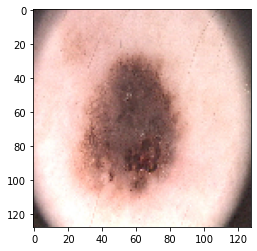

In [4]:
plt.imshow(images[2].convert('RGBA'))
plt.show()

Посмотрим на цели

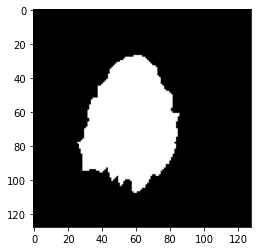

In [5]:
plt.imshow(segments[2].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [6]:
xTrain_Test = []

for img in images:
    x = np.array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [7]:
print(xTrain_Test.shape)

(200, 128, 128, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Car	  ( 0, 0, 0)	Object

Void	( 255,255, 255)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

  - каждому классу (цвету) ставим в соответствие свою карту ответов y_cat, где 1 , если цвет этого пикселя равен номеру карты и 0 в противном случае
  - для визуализации строим карту цветов y_ind, где пиксель содержит номер цвета

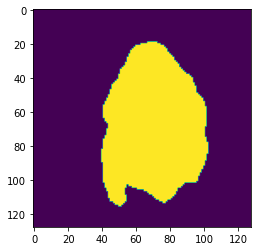

In [8]:
def Color2index(y):
  #y - входное изображение разметки (УхХхС - цветное )
  # карту цветов y_ind
  # карту ответов one-hot-encoding y_cat

  # список актуальных цветов разметки
    arr_col=[[0,0,0],[255,255,255]]
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        #найдем все точки цвета i_color
        ind_i = np.where((y[:,:,0] == i_color[0]) & (y[:,:,1] == i_color[1]) & (y[:,:,2] == i_color[2]))

        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


Проверяем максимальное значение слоя 1 (по нашей схеме должна быть 1)

In [9]:
np.max(cat_yi[:,:,1] )

1.0

Оценим размер карты ответа:
  - число каналов равно числу классов
  - размер карты равер размеру картинки входа

In [10]:
cat_yi.shape

(128, 128, 2)

Сегментированную картинку в  One hot encoding (разметка на 2 класса)**

In [11]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [12]:
print(yTrain_Test.shape)

(200, 128, 128, 2)


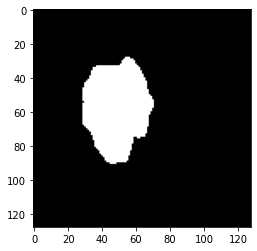

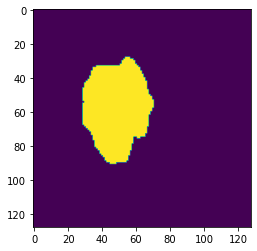

In [13]:
n = 1
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,n]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [14]:
N = 150
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [15]:
yTest.shape

(50, 128, 128, 2)

In [16]:
print(xTrain.shape)
print(yTrain.shape)

(150, 128, 128, 3)
(150, 128, 128, 2)


#Создаём и обучаем U-net

In [17]:
from tensorflow.keras.utils import plot_model

**Unet**

In [18]:
def Unet(num_classes = 2, input_shape= (128, 128, 3)):
  #num_classes = 2, - число классов ответа
  #input_shape= (112, 160, 3) - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 56x80

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 28x40

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #14x20

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out) # 7x10

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # 7x10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #28x40
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    #x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 56x80
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    #x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 112x160
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    #x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

                                                                 
 batch_normalization_15 (Bat  (None, 16, 16, 512)      2048      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       590080    
          

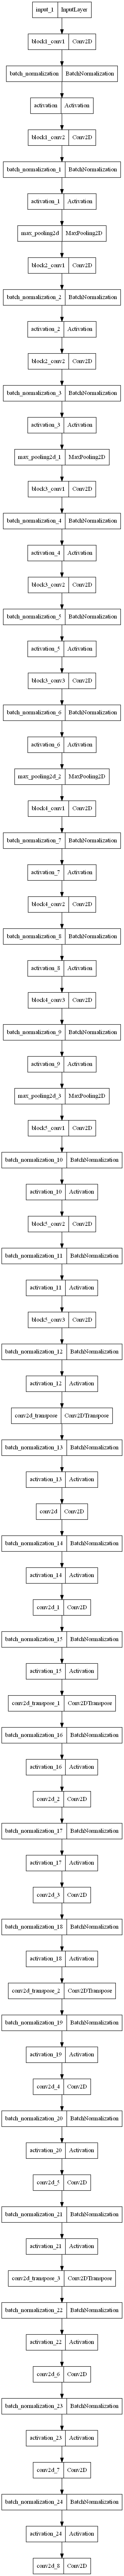

In [19]:
modelC = Unet(2, (128, 128, 3))

plot_model(modelC, to_file='modelC.png')

Обучаем модель

In [20]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=20, validation_data=(xTrain, yTrain))

Epoch 1/10
8/8 [==============================] - 11s 544ms/step - loss: 0.6956 - dice_coef: 0.5336 - val_loss: 0.6936 - val_dice_coef: 0.4991
Epoch 2/10
8/8 [==============================] - 2s 245ms/step - loss: 0.4555 - dice_coef: 0.6623 - val_loss: 0.6872 - val_dice_coef: 0.5024
Epoch 3/10
8/8 [==============================] - 2s 246ms/step - loss: 0.3430 - dice_coef: 0.7501 - val_loss: 0.6725 - val_dice_coef: 0.5109
Epoch 4/10
8/8 [==============================] - 2s 248ms/step - loss: 0.2701 - dice_coef: 0.7999 - val_loss: 0.6539 - val_dice_coef: 0.5229
Epoch 5/10
8/8 [==============================] - 2s 249ms/step - loss: 0.2245 - dice_coef: 0.8280 - val_loss: 0.6357 - val_dice_coef: 0.5368
Epoch 6/10
8/8 [==============================] - 2s 257ms/step - loss: 0.1914 - dice_coef: 0.8557 - val_loss: 0.6189 - val_dice_coef: 0.5529
Epoch 7/10
8/8 [==============================] - 2s 251ms/step - loss: 0.1813 - dice_coef: 0.8672 - val_loss: 0.6071 - val_dice_coef: 0.5680
Epoch

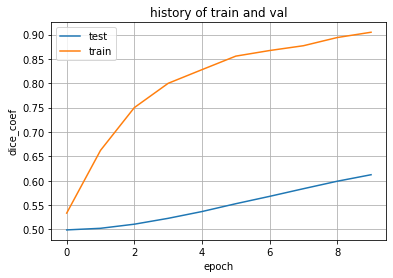

In [21]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.title('history of train and val')
plt.show()

Тест модели

In [ ]:
history = modelC.fit(xTrain, yTrain, epochs=500, batch_size=40, validation_data=(xTest, yTest))

Epoch 1/500
4/4 [==============================] - 12s 2s/step - loss: 0.1161 - dice_coef: 0.9128 - val_loss: 0.8055 - val_dice_coef: 0.5469
Epoch 2/500
4/4 [==============================] - 2s 401ms/step - loss: 0.1156 - dice_coef: 0.9148 - val_loss: 0.8193 - val_dice_coef: 0.5487
Epoch 3/500
4/4 [==============================] - 2s 406ms/step - loss: 0.1032 - dice_coef: 0.9212 - val_loss: 0.8387 - val_dice_coef: 0.5510
Epoch 4/500
4/4 [==============================] - 2s 403ms/step - loss: 0.0999 - dice_coef: 0.9256 - val_loss: 0.8555 - val_dice_coef: 0.5528
Epoch 5/500
4/4 [==============================] - 2s 402ms/step - loss: 0.1036 - dice_coef: 0.9242 - val_loss: 0.8721 - val_dice_coef: 0.5545
Epoch 6/500
4/4 [==============================] - 2s 398ms/step - loss: 0.0901 - dice_coef: 0.9318 - val_loss: 0.8948 - val_dice_coef: 0.5566
Epoch 7/500
4/4 [==============================] - 2s 397ms/step - loss: 0.0936 - dice_coef: 0.9320 - val_loss: 0.9125 - val_dice_coef: 0.5581
E

Epoch 58/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0248 - dice_coef: 0.9815 - val_loss: 1.3831 - val_dice_coef: 0.6557
Epoch 59/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0232 - dice_coef: 0.9825 - val_loss: 1.2370 - val_dice_coef: 0.6881
Epoch 60/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0229 - dice_coef: 0.9827 - val_loss: 1.0607 - val_dice_coef: 0.7313
Epoch 61/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0218 - dice_coef: 0.9835 - val_loss: 1.0520 - val_dice_coef: 0.7357
Epoch 62/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0281 - dice_coef: 0.9801 - val_loss: 1.0388 - val_dice_coef: 0.7331
Epoch 63/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0320 - dice_coef: 0.9797 - val_loss: 1.5466 - val_dice_coef: 0.6495
Epoch 64/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0314 - dice_coef: 0.9795 - val_loss: 1.2298 - val_dice_coef:

Epoch 115/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0094 - dice_coef: 0.9922 - val_loss: 0.5941 - val_dice_coef: 0.8902
Epoch 116/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0089 - dice_coef: 0.9925 - val_loss: 0.6096 - val_dice_coef: 0.8877
Epoch 117/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0089 - dice_coef: 0.9924 - val_loss: 0.6217 - val_dice_coef: 0.8859
Epoch 118/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0090 - dice_coef: 0.9924 - val_loss: 0.6193 - val_dice_coef: 0.8872
Epoch 119/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0086 - dice_coef: 0.9927 - val_loss: 0.6124 - val_dice_coef: 0.8899
Epoch 120/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0086 - dice_coef: 0.9928 - val_loss: 0.5819 - val_dice_coef: 0.8955
Epoch 121/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0087 - dice_coef: 0.9927 - val_loss: 0.6201 - val_dic

4/4 [==============================] - 2s 399ms/step - loss: 0.0056 - dice_coef: 0.9952 - val_loss: 0.6581 - val_dice_coef: 0.9042
Epoch 172/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0056 - dice_coef: 0.9953 - val_loss: 0.6979 - val_dice_coef: 0.8988
Epoch 173/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0059 - dice_coef: 0.9951 - val_loss: 0.6655 - val_dice_coef: 0.9040
Epoch 174/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0055 - dice_coef: 0.9954 - val_loss: 0.6618 - val_dice_coef: 0.9048
Epoch 175/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0048 - dice_coef: 0.9958 - val_loss: 0.6737 - val_dice_coef: 0.9039
Epoch 176/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0054 - dice_coef: 0.9953 - val_loss: 0.6331 - val_dice_coef: 0.9094
Epoch 177/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0049 - dice_coef: 0.9958 - val_loss: 0.6706 - val_dice_coef: 0.9042

4/4 [==============================] - 2s 399ms/step - loss: 0.0027 - dice_coef: 0.9975 - val_loss: 0.6822 - val_dice_coef: 0.9124
Epoch 228/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0026 - dice_coef: 0.9976 - val_loss: 0.6813 - val_dice_coef: 0.9126
Epoch 229/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0025 - dice_coef: 0.9976 - val_loss: 0.6864 - val_dice_coef: 0.9123
Epoch 230/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0025 - dice_coef: 0.9976 - val_loss: 0.6700 - val_dice_coef: 0.9146
Epoch 231/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0025 - dice_coef: 0.9976 - val_loss: 0.6746 - val_dice_coef: 0.9140
Epoch 232/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0024 - dice_coef: 0.9977 - val_loss: 0.6625 - val_dice_coef: 0.9157
Epoch 233/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0024 - dice_coef: 0.9977 - val_loss: 0.6676 - val_dice_coef: 0.9151

4/4 [==============================] - 2s 398ms/step - loss: 0.0117 - dice_coef: 0.9917 - val_loss: 0.9934 - val_dice_coef: 0.8270
Epoch 284/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0102 - dice_coef: 0.9924 - val_loss: 0.9756 - val_dice_coef: 0.8332
Epoch 285/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0106 - dice_coef: 0.9923 - val_loss: 0.9653 - val_dice_coef: 0.8300
Epoch 286/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0092 - dice_coef: 0.9930 - val_loss: 0.9575 - val_dice_coef: 0.8323
Epoch 287/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0090 - dice_coef: 0.9932 - val_loss: 0.9482 - val_dice_coef: 0.8322
Epoch 288/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0090 - dice_coef: 0.9932 - val_loss: 0.9660 - val_dice_coef: 0.8258
Epoch 289/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0085 - dice_coef: 0.9935 - val_loss: 0.9453 - val_dice_coef: 0.8250

4/4 [==============================] - 2s 399ms/step - loss: 0.0047 - dice_coef: 0.9964 - val_loss: 0.5873 - val_dice_coef: 0.9081
Epoch 340/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0038 - dice_coef: 0.9969 - val_loss: 0.6042 - val_dice_coef: 0.9058
Epoch 341/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0042 - dice_coef: 0.9966 - val_loss: 0.5929 - val_dice_coef: 0.9081
Epoch 342/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0036 - dice_coef: 0.9970 - val_loss: 0.5882 - val_dice_coef: 0.9093
Epoch 343/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0041 - dice_coef: 0.9968 - val_loss: 0.5849 - val_dice_coef: 0.9100
Epoch 344/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0034 - dice_coef: 0.9971 - val_loss: 0.5993 - val_dice_coef: 0.9077
Epoch 345/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0040 - dice_coef: 0.9967 - val_loss: 0.5832 - val_dice_coef: 0.9105

4/4 [==============================] - 2s 399ms/step - loss: 0.0017 - dice_coef: 0.9984 - val_loss: 0.6232 - val_dice_coef: 0.9173
Epoch 396/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0016 - dice_coef: 0.9986 - val_loss: 0.6318 - val_dice_coef: 0.9165
Epoch 397/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0016 - dice_coef: 0.9985 - val_loss: 0.6290 - val_dice_coef: 0.9170
Epoch 398/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0015 - dice_coef: 0.9986 - val_loss: 0.6394 - val_dice_coef: 0.9163
Epoch 399/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0017 - dice_coef: 0.9984 - val_loss: 0.6393 - val_dice_coef: 0.9165
Epoch 400/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0015 - dice_coef: 0.9986 - val_loss: 0.6427 - val_dice_coef: 0.9163
Epoch 401/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0019 - dice_coef: 0.9983 - val_loss: 0.6426 - val_dice_coef: 0.9162

4/4 [==============================] - 2s 399ms/step - loss: 0.0016 - dice_coef: 0.9987 - val_loss: 0.7373 - val_dice_coef: 0.9126
Epoch 452/500
4/4 [==============================] - 2s 401ms/step - loss: 0.0016 - dice_coef: 0.9986 - val_loss: 0.7174 - val_dice_coef: 0.9149
Epoch 453/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0016 - dice_coef: 0.9986 - val_loss: 0.7301 - val_dice_coef: 0.9132
Epoch 454/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0017 - dice_coef: 0.9986 - val_loss: 0.7244 - val_dice_coef: 0.9149
Epoch 455/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0016 - dice_coef: 0.9986 - val_loss: 0.7521 - val_dice_coef: 0.9121
Epoch 456/500
4/4 [==============================] - 2s 399ms/step - loss: 0.0016 - dice_coef: 0.9987 - val_loss: 0.7407 - val_dice_coef: 0.9138
Epoch 457/500
4/4 [==============================] - 2s 400ms/step - loss: 0.0015 - dice_coef: 0.9987 - val_loss: 0.7436 - val_dice_coef: 0.9134

In [ ]:
pred = modelC.predict(xTest)
print(pred.shape)

In [ ]:
n = 31
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()